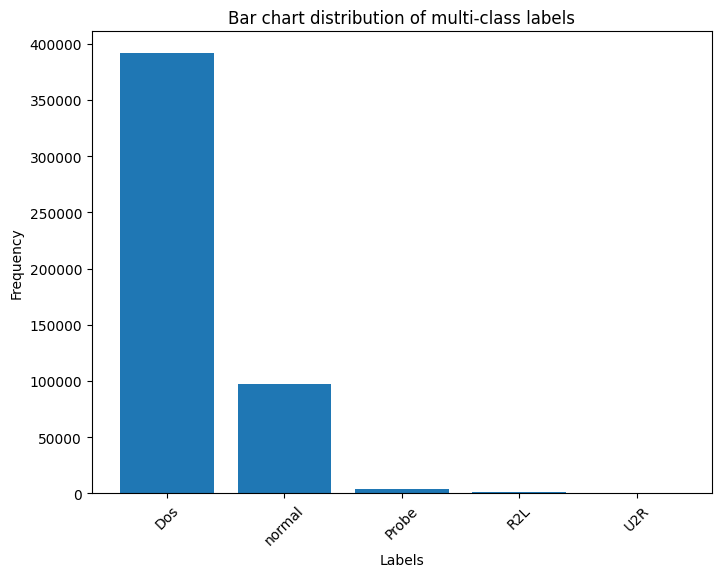

<ipython-input-10-7fa514200cf9>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numeric_multi['intrusion'] = multi_data['intrusion']



Decision Tree Classifier Multi-class Set-Accuracy is  99.37816282741589
              precision    recall  f1-score   support

         Dos       1.00      1.00      1.00     97867
       Probe       0.96      0.96      0.96      1042
         R2L       0.90      0.90      0.90       296
         U2R       0.62      0.28      0.38        18
      normal       0.98      0.99      0.98     24282

    accuracy                           0.99    123505
   macro avg       0.89      0.82      0.84    123505
weighted avg       0.99      0.99      0.99    123505

[[97458     2     0     0   407]
 [   12   999     0     0    31]
 [    1     0   267     2    26]
 [    0     0     2     5    11]
 [  200    44    29     1 24008]]
Mean Absolute Error -  0.022630662726205418
Mean Squared Error -  0.08615845512327436
Root Mean Squared Error -  0.2935276053853783
R2 Score -  96.58923064946251
Accuracy -  99.37816282741589


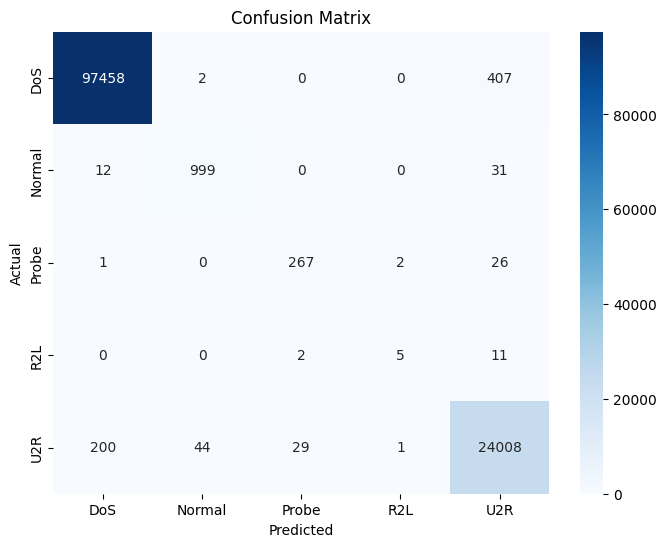

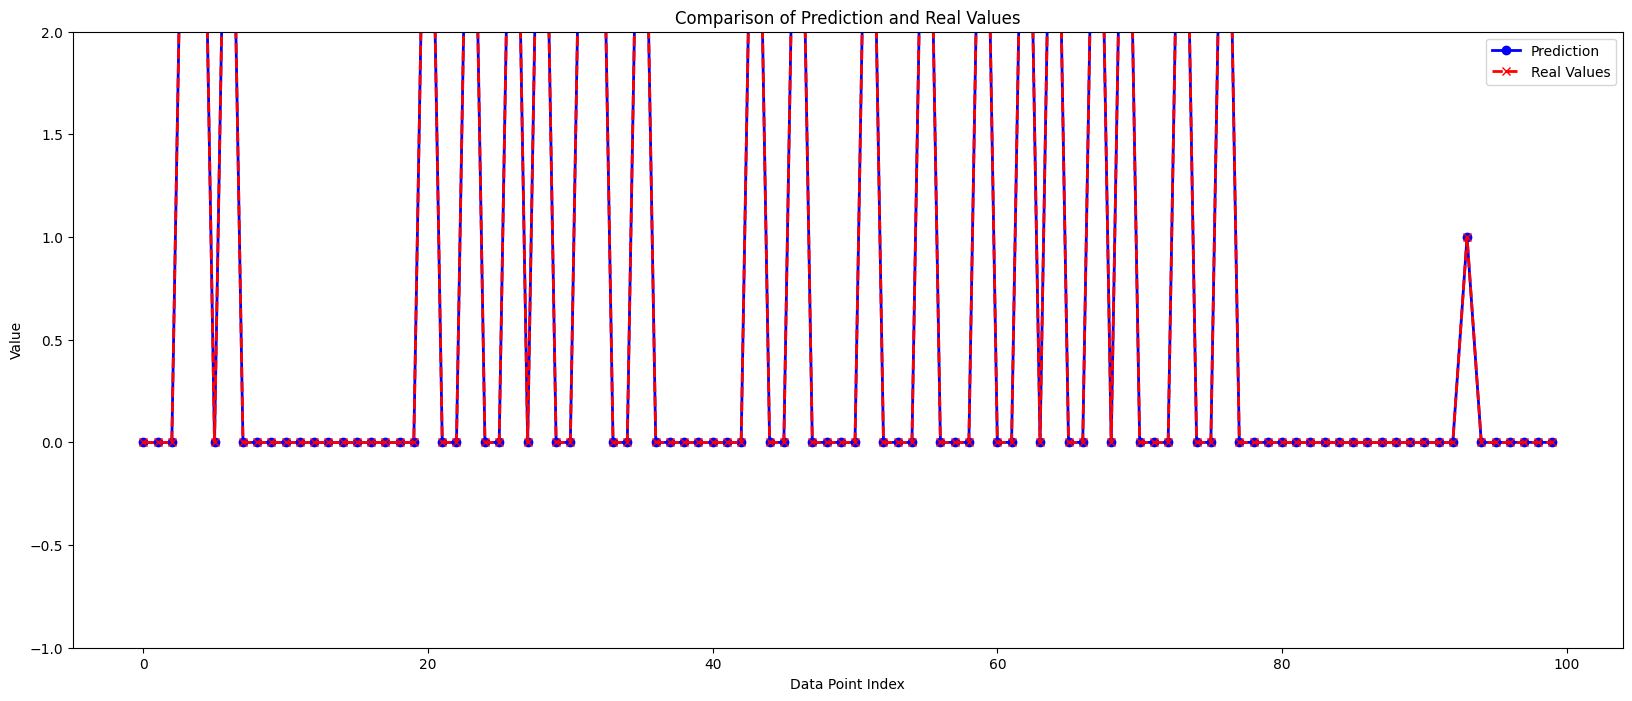

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
data = pd.read_csv('/content/kddcup99_csv (1).csv')



data.head()
# xử lí dữ liệu missing data
for i in range(len(data.columns)):
    missing_data = data[data.columns[i]].isna().sum()
    perc = missing_data / len(data) * 100
    if perc != 0:  # Thêm dấu hai chấm sau điều kiện của if
        print('>%d, missing entries: %d, percentage %.2f' % (i, missing_data, perc))


X_main= data.iloc[:, :-1].values
y_main = data.iloc[:, -1].values

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
imputer.fit(X_main[:, 4:41])
X_main[:, 4:41] = imputer.transform(X_main[:, 4:41])


data['label'].value_counts()

# chia thành các nhãn tấn công : DOS, R2L, U2R Probe
def change_label(data):
  data.label.replace(['apache2','back','land','neptune','mailbomb','pod','processtable','smurf','teardrop','udpstorm','worm'],'Dos',inplace=True)
  data.label.replace(['ftp_write','guess_passwd','httptunnel','imap','multihop','named','phf','sendmail',
       'snmpgetattack','snmpguess','spy','warezclient','warezmaster','xlock','xsnoop'],'R2L',inplace=True)
  data.label.replace(['ipsweep','mscan','nmap','portsweep','saint','satan'],'Probe',inplace=True)
  data.label.replace(['buffer_overflow','loadmodule','perl','ps','rootkit','sqlattack','xterm'],'U2R',inplace=True)

# gọi hàm Change_label()
change_label(data)
data.label.value_counts()

# chọn các cột thuộc tính số từ dữ liệu
numeric_col = data.select_dtypes(include='number').columns
# sử dụng bộ chia tỷ lệ tiêu chuẩn để chuẩn hóa
std_scaler = StandardScaler()
def normalization(data,col):
  for i in col:
    arr = data[i]
    arr = np.array(arr)
    data[i] = std_scaler.fit_transform(arr.reshape(len(arr),1))
  return data

data.head()

# gọi hàm chuẩn hóa()
data = normalization(data.copy(),numeric_col)

# dữ liệu sau khi chuẩn hóa
data.head(144393)

# chọn thuộc tính dữ liệu phân loại
cat_col = ['protocol_type','service','flag']

# tạo một khung dữ liệu chỉ có các thuộc tính phân loại
categorical = data[cat_col]
categorical.head()

# thuộc tính phân loại one-hot-encoding sử dụng hàm pandas.get_dummies()
categorical = pd.get_dummies(categorical,columns=cat_col)
categorical.head()


#tạo một khung dữ liệu với nhãn nhiều lớp (Dos,Probe,R2L,U2R,normal)
multi_data = data.copy()
multi_label = pd.DataFrame(multi_data.label)

# nhãn mã hóa (0,1,2,3,4) nhãn nhiều lớp (Dos,normal,Probe,R2L,U2R)
le2 = preprocessing.LabelEncoder()
enc_label = multi_label.apply(le2.fit_transform)
multi_data['intrusion'] = enc_label

le2.classes_

np.save("le2_classes.npy",le2.classes_,allow_pickle=True)

# one-hot-encoding nhãn tấn công
multi_data = pd.get_dummies(multi_data,columns=['label'],prefix="",prefix_sep="")
multi_data['label'] = multi_label
multi_data


import matplotlib.pyplot as plt
label_counts = multi_data['label'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(label_counts.index, label_counts.values)
plt.title('Bar chart distribution of multi-class labels')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()



# tạo khung dữ liệu chỉ có thuộc tính số của tập dữ liệu nhiều lớp và thuộc tính nhãn được mã hóa
numeric_multi = multi_data[numeric_col]
numeric_multi['intrusion'] = multi_data['intrusion']

# tìm các thuộc tính có mối tương quan lớn hơn 0,5 với thuộc tính nhãn tấn công được mã hóa
corr = numeric_multi.corr()
corr_y = abs(corr['intrusion'])
highest_corr = corr_y[corr_y >0.5]
highest_corr.sort_values(ascending=True)

# chọn các thuộc tính được tìm thấy bằng cách sử dụng hệ số tương quan Pearson
numeric_multi = multi_data[['count','logged_in','srv_serror_rate','serror_rate','dst_host_serror_rate',
                        'dst_host_same_srv_rate','dst_host_srv_serror_rate','dst_host_srv_count','same_srv_rate']]

# nối thuộc tính đã chọn với khung dữ liệu phân loại được mã hóa một lần
numeric_multi = numeric_multi.join(categorical)
# sau đó nối thuộc tính nhãn tấn công được mã hóa, mã hóa một lần và mã gốc
multi_data = numeric_multi.join(multi_data[['intrusion','Dos','Probe','R2L','U2R','normal','label']])

# tập dữ liệu cuối cùng để phân loại nhiều lớp
multi_data

multi_data.head(144472)

X = multi_data.iloc[:,0:89].to_numpy() # # tập dữ liệu không bao gồm thuộc tính đích (encoded, one-hot-encoded, original)
Y = multi_data['intrusion'] # target attribute
# bước 2 : train
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import pickle
from os import path

# chia tập dữ liệu 75% cho đào tạo và 25% cho kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

# sử dụng Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)

print()
#bước 3: Đánh giá

from sklearn.metrics import accuracy_score
y_pred = dt.predict(X_test)

# Tính toán độ chính xác của dữ liệu dự đoán
ac = accuracy_score(y_test, y_pred) * 100  # tính toán độ chính xác theo tỷ lệ phần trăm

print("Decision Tree Classifier Multi-class Set-Accuracy is ", ac)

# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred,target_names=le2.classes_))

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, accuracy_score
import numpy as np

# Giả sử y_test và y_pred đã được xác định ở bước trước

labels = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
confusion = confusion_matrix(y_test, y_pred)
print(confusion)

print("Mean Absolute Error - ", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error - ", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error - ", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score - ", explained_variance_score(y_test, y_pred) * 100)
print("Accuracy - ", accuracy_score(y_test, y_pred) * 100)


plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

import matplotlib.pyplot as plt

# Dự đoán và giá trị thực tế của mô hình
y_pred_values = y_pred[300:400]
y_test_values = y_test.values[300:400]

# Tạo các điểm dự đoán và giá trị thực tế trên trục x
x_values = list(range(len(y_pred_values)))

plt.figure(figsize=(20, 8))

# Hiển thị dự đoán với màu xanh
plt.plot(x_values, y_pred_values, label="Prediction", linewidth=2.0, color='blue', marker='o')

# Hiển thị giá trị thực tế với màu đỏ
plt.plot(x_values, y_test_values, label="Real Values", linewidth=2.0, color='red', linestyle='dashed', marker='x')

# Thêm tiêu đề, chú thích và giới hạn trục y
plt.title("Comparison of Prediction and Real Values")
plt.xlabel("Data Point Index")
plt.ylabel("Value")
plt.legend()
plt.ylim((-1, 2))  # Điều chỉnh giới hạn trục y tùy theo giá trị dự đoán và giá trị thực tế
plt.show()